<a href="https://colab.research.google.com/github/heegeunyoon/python101/blob/main/1_4_data_analysis_from_ecos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECOS open API
- https://ecos.bok.or.kr/api/#/
- 회원가입 후, '서비스 이용 - 인증키 신청'
    - 아래 url에서 your_auth_key 부분을 인증키로 대체
- '개발 가이드 - 언어별 개발 가이드 - 파이썬' 참고
- '개발 가이드 - 통계코드검색'에서 원하는 통계항목의 코드 검색

'1.1.1.1.1. 본원통화 구성내역(평잔, 계절조정계열)'

- 인증키를 이용하여 2010년부터 2020년까지, 10,000개 이내 자료를 국문 json 파일 형식으로 입수하기 위한 url 주소 생성

ecos open api웹페이지에서 인증키 복사

In [83]:
your_auth_key = "xxxxxxxxxxxx"

In [85]:
url = f'http://ecos.bok.or.kr/api/StatisticSearch/{your_auth_key}/json/kr/1/10000/102Y004/A/1950/2023/ABA1/?/?/'
print(url)

http://ecos.bok.or.kr/api/StatisticSearch/J79YQ3SYY18K2W9WFSMT/json/kr/1/10000/102Y004/A/1950/2023/ABA1/?/?/


In [86]:
import json
from urllib.request import urlopen

result = urlopen(url)
data = json.loads(result.read()) # 지정된 URL에서 JSON 형식의 데이터를 가져와서 Python의 데이터 구조로 변환하는 과정(파싱)

In [87]:
type(data)

dict

In [88]:
data.keys() # 딕셔너리의 키값

dict_keys(['StatisticSearch'])

In [89]:
data = data['StatisticSearch']

In [90]:
data.keys()

dict_keys(['list_total_count', 'row'])

In [91]:
data['list_total_count']

22

In [92]:
data['row']

[{'STAT_CODE': '102Y004',
  'STAT_NAME': '1.1.1.1.1. 본원통화 구성내역(평잔, 계절조정계열)',
  'ITEM_CODE1': 'ABA1',
  'ITEM_NAME1': '본원통화(평잔,계절조정계열)',
  'ITEM_CODE2': None,
  'ITEM_NAME2': None,
  'ITEM_CODE3': None,
  'ITEM_NAME3': None,
  'ITEM_CODE4': None,
  'ITEM_NAME4': None,
  'UNIT_NAME': '십억원',
  'WGT': None,
  'TIME': '2002',
  'DATA_VALUE': '33579.3'},
 {'STAT_CODE': '102Y004',
  'STAT_NAME': '1.1.1.1.1. 본원통화 구성내역(평잔, 계절조정계열)',
  'ITEM_CODE1': 'ABA1',
  'ITEM_NAME1': '본원통화(평잔,계절조정계열)',
  'ITEM_CODE2': None,
  'ITEM_NAME2': None,
  'ITEM_CODE3': None,
  'ITEM_NAME3': None,
  'ITEM_CODE4': None,
  'ITEM_NAME4': None,
  'UNIT_NAME': '십억원',
  'WGT': None,
  'TIME': '2003',
  'DATA_VALUE': '35754.7'},
 {'STAT_CODE': '102Y004',
  'STAT_NAME': '1.1.1.1.1. 본원통화 구성내역(평잔, 계절조정계열)',
  'ITEM_CODE1': 'ABA1',
  'ITEM_NAME1': '본원통화(평잔,계절조정계열)',
  'ITEM_CODE2': None,
  'ITEM_NAME2': None,
  'ITEM_CODE3': None,
  'ITEM_NAME3': None,
  'ITEM_CODE4': None,
  'ITEM_NAME4': None,
  'UNIT_NAME': '십억원',
  'WGT':

In [93]:
data = data['row']

In [94]:
data

[{'STAT_CODE': '102Y004',
  'STAT_NAME': '1.1.1.1.1. 본원통화 구성내역(평잔, 계절조정계열)',
  'ITEM_CODE1': 'ABA1',
  'ITEM_NAME1': '본원통화(평잔,계절조정계열)',
  'ITEM_CODE2': None,
  'ITEM_NAME2': None,
  'ITEM_CODE3': None,
  'ITEM_NAME3': None,
  'ITEM_CODE4': None,
  'ITEM_NAME4': None,
  'UNIT_NAME': '십억원',
  'WGT': None,
  'TIME': '2002',
  'DATA_VALUE': '33579.3'},
 {'STAT_CODE': '102Y004',
  'STAT_NAME': '1.1.1.1.1. 본원통화 구성내역(평잔, 계절조정계열)',
  'ITEM_CODE1': 'ABA1',
  'ITEM_NAME1': '본원통화(평잔,계절조정계열)',
  'ITEM_CODE2': None,
  'ITEM_NAME2': None,
  'ITEM_CODE3': None,
  'ITEM_NAME3': None,
  'ITEM_CODE4': None,
  'ITEM_NAME4': None,
  'UNIT_NAME': '십억원',
  'WGT': None,
  'TIME': '2003',
  'DATA_VALUE': '35754.7'},
 {'STAT_CODE': '102Y004',
  'STAT_NAME': '1.1.1.1.1. 본원통화 구성내역(평잔, 계절조정계열)',
  'ITEM_CODE1': 'ABA1',
  'ITEM_NAME1': '본원통화(평잔,계절조정계열)',
  'ITEM_CODE2': None,
  'ITEM_NAME2': None,
  'ITEM_CODE3': None,
  'ITEM_NAME3': None,
  'ITEM_CODE4': None,
  'ITEM_NAME4': None,
  'UNIT_NAME': '십억원',
  'WGT':

딕셔너리 데이터를 이용하여 판다스 데이터프레임 생성

In [95]:
import pandas as pd

df = pd.DataFrame(data)

In [96]:
df

,STAT_CODE,STAT_NAME,ITEM_CODE1,ITEM_NAME1,ITEM_CODE2,ITEM_NAME2,ITEM_CODE3,ITEM_NAME3,ITEM_CODE4,ITEM_NAME4,UNIT_NAME,WGT,TIME,DATA_VALUE
0,102Y004,"1.1.1.1.1. 본원통화 구성내역(평잔, 계절조정계열)",ABA1,"본원통화(평잔,계절조정계열)",None,None,None,None,None,None,십억원,None,2002,33579.3
1,102Y004,"1.1.1.1.1. 본원통화 구성내역(평잔, 계절조정계열)",ABA1,"본원통화(평잔,계절조정계열)",None,None,None,None,None,None,십억원,None,2003,35754.7
2,102Y004,"1.1.1.1.1. 본원통화 구성내역(평잔, 계절조정계열)",ABA1,"본원통화(평잔,계절조정계열)",None,None,None,None,None,None,십억원,None,2004,37272.4
3,102Y004,"1.1.1.1.1. 본원통화 구성내역(평잔, 계절조정계열)",ABA1,"본원통화(평잔,계절조정계열)",None,None,None,None,None,None,십억원,None,2005,38785.2
4,102Y004,"1.1.1.1.1. 본원통화 구성내역(평잔, 계절조정계열)",ABA1,"본원통화(평잔,계절조정계열)",None,None,None,None,None,None,십억원,None,2006,41664
5,102Y004,"1.1.1.1.1. 본원통화 구성내역(평잔, 계절조정계열)",ABA1,"본원통화(평잔,계절조정계열)",None,None,None,None,None,None,십억원,None,2007,48543.7
6,102Y004,"1.1.1.1.1. 본원통화 구성내역(평잔, 계절조정계열)",ABA1,"본원통화(평잔,계절조정계열)",None,None,None,None,None,None,십억원,None,2008,52272.8
7,102Y004,"1.1.1.1.1. 본원통화 구성내역(평잔, 계절조정계열)",ABA1,"본원통화(평잔,계절조정계열)",None,None,None,None,None,None,십억원,None,2009,61739.6
8,102Y004,"1.1.1.1.1. 본원통화 구성내역(평잔, 계절조정계열)",ABA1,"본원통화(평잔,계절조정계열)",None,None,None,None,None,None,십억원,None,2010,67585.1
9,102Y004,"1.1.1.1.1. 본원통화 구성내역(평잔, 계절조정계열)",ABA1,"본원통화(평잔,계절조정계열)",None,None,None,None,None,None,십억원,None,2011,75232


In [97]:
df = df.set_index('TIME')
df = df['DATA_VALUE'] # df가 시리즈로 추출

In [98]:
type(df)

pandas.core.series.Series

In [99]:
df.index = pd.to_datetime(df.index)
df.index.names = ['Dates']
df = df.to_frame('DATA_VALUE')
df

,DATA_VALUE
Dates,
2002-01-01,33579.3
2003-01-01,35754.7
2004-01-01,37272.4
2005-01-01,38785.2
2006-01-01,41664
2007-01-01,48543.7
2008-01-01,52272.8
2009-01-01,61739.6
2010-01-01,67585.1


In [ ]:
type(df)

pandas.core.indexes.datetimes.DatetimeIndex

In [101]:
df.index = pd.to_datetime(df.index)
df

,DATA_VALUE
Dates,
2002-01-01,33579.3
2003-01-01,35754.7
2004-01-01,37272.4
2005-01-01,38785.2
2006-01-01,41664
2007-01-01,48543.7
2008-01-01,52272.8
2009-01-01,61739.6
2010-01-01,67585.1


In [102]:
from pandas.tseries.offsets import YearEnd, QuarterEnd, MonthEnd, YearBegin, QuarterBegin, MonthBegin
import json
from urllib.request import urlopen
import pandas as pd


def necos(code = '102Y004', item1 = 'ABA1', item2 = '?', item3 = '?',
         freq = 'A', first = None, last = None, N = '10000',
         detail = True, col = None):

    if first is None:
        if (freq == 'M'):
            first = '190001'
            last = '210012'
        elif (freq == 'Q'):
            first = '1900Q1'
            last = '2100Q4'
        elif (freq == 'A'):
            first = '1900'
            last = '2100'
        elif (freq == 'D'):
            first = '20200101'
            last = '20301231'
            print('Data is being retreived from 2020-01-01.')
        else:
            print('freq must be one of D, M, Q, A.')
            return

    '''retreive monthly, quarterly, annul time series from ecos.
    run 'open_ecosapi() to explore ecos api codes.'''
    ecos_key = f"http://ecos.bok.or.kr/api/StatisticSearch/{your_auth_key}"

    url  = f"{ecos_key}/json/kr/1/{N}/{code}/{freq}/{first}/{last}/{item1}/{item2}/{item3}/"
    result = urlopen(url)
    data = json.loads(result.read())
    data = data["StatisticSearch"]["row"]
    df = pd.DataFrame(data)

    if detail: # 데이터 정보 프린트
        print(f"통계: {df.loc[0, 'STAT_NAME']}",
            f"단위: {df.loc[0, 'UNIT_NAME']}",
            f"기간: {df.loc[0, 'TIME']} - {df.loc[df.index[-1], 'TIME']}",
            f"항목: {df.loc[0, 'ITEM_NAME1']}",)

    df = df.set_index("TIME")
    df.index.names = ['DATE']

    if (freq == 'M'):
        df.index = pd.to_datetime(df.index, format='%Y%m')
    elif (freq == 'Q'):
        df.index = pd.to_datetime(df.index)
    elif (freq == 'A'):
        df.index = pd.to_datetime(df.index, format='%Y')
    elif (freq == 'D'):
        df.index = pd.to_datetime(df.index, format='%Y%m%d')

    df["DATA_VALUE"] = df["DATA_VALUE"].astype("float")

    return df['DATA_VALUE'].to_frame(col)

In [103]:
cash = necos('102Y001', 'ABA203', freq='M', col = 'cash')

통계: 1.1.1.1.4. 본원통화 구성내역(말잔, 원계열) 단위: 십억원 기간: 200201 - 202505 항목: 현금통화


In [104]:
cash

,cash
DATE,
2002-01-01,16376.8
2002-02-01,17389.5
2002-03-01,17109.0
2002-04-01,16836.6
2002-05-01,16652.6
...,...
2025-01-01,188618.2
2025-02-01,186026.4
2025-03-01,185836.4


In [105]:
kospi = necos('802Y001', '0001000', freq='D', col = '코스피')

Data is being retreived from 2020-01-01.
통계: 1.5.1.1. 주식시장(일) 단위: 1980.01.04=100  기간: 20200102 - 20250715 항목: KOSPI지수


In [106]:
kospi

,코스피
DATE,
2020-01-02,2175.17
2020-01-03,2176.46
2020-01-06,2155.07
2020-01-07,2175.54
2020-01-08,2151.31
...,...
2025-07-09,3133.74
2025-07-10,3183.23
2025-07-11,3175.77


In [107]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

!apt-get -qq install fonts-nanum


fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정

plt.rcParams['axes.unicode_minus'] = False # 폰트가 한글인 경우, - 표시 오류 수정

'apt-get'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


<Axes: xlabel='DATE'>

c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabt

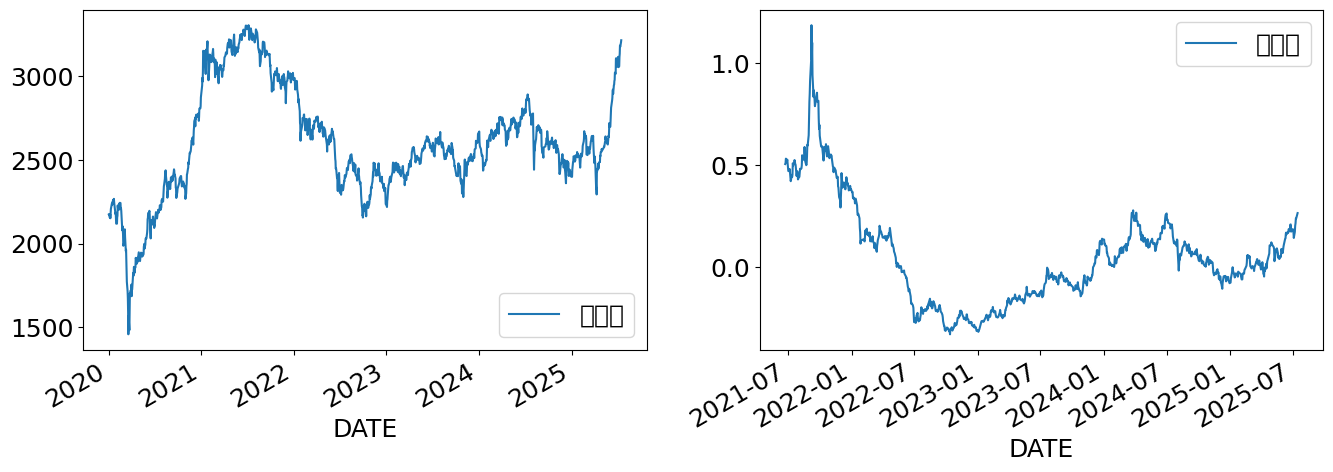

In [108]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

kospi.plot(ax=ax[0])
kospi.pct_change(365).plot(ax=ax[1])

